###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode
from micrograd.eval import evaluate, calc_accuracy, calc_sq_loss

%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

# Get MNIST dataset

In [3]:
from torchvision import datasets as dts

MNIST_DATASET = dts.MNIST(root = 'data', train = True, download=True)

X_train = MNIST_DATASET.data / 255.0 # * 2 - 1
X_train = X_train.reshape(X_train.shape[0], 784)

Y_train = MNIST_DATASET.targets

In [4]:
ALL_POSITIVE_CLASSES = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

enc, dec = oh_encode(ALL_POSITIVE_CLASSES)
enc(ALL_POSITIVE_CLASSES)

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [5]:
import torch


def append_noise(X, noise_size, min=-1.0, max=1.0):
    noise_shape = torch.Size([noise_size]) + X.shape[1:]
    noise_tensor = torch.empty(noise_shape).uniform_(min, max)
    return torch.concat([X, noise_tensor])


def append_void(X, void_size, void=-1.0):
    void_shape = torch.Size([void_size]) + X.shape[1:]
    void_tensor = torch.empty(void_shape).fill_(void)
    return torch.concat([X, void_tensor])


def get_batch(X, Y, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=-1):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y = X[ri], Y[ri]

    if noise_ratio > 0.0:
        noise_size = round(batch_size * noise_ratio)
        X = append_noise(X, noise_size)
        Y = torch.concat([Y, torch.tensor([void_class] * noise_size)])

    if void_ratio > 0.0:
        void_size = round(batch_size * void_ratio)
        X = append_void(X, void_size, void=np.random.uniform(0, 1))
        Y = torch.concat([Y, torch.tensor([void_class] * void_size)])

    return X, Y


def batch2vals(batch):
    return tuple(map(arr2vals, batch))


# save/load

In [6]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='sbin') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [7]:
import matplotlib.pyplot as plt


def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]


def select_batch(X, Y, selector, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=torch.nan):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], Y[idx], batch_size, noise_ratio, void_ratio, void_class)


def draw_neuron(model, neuron, layer=0):
    w = np.array([p.data for p in model.layers[layer].neurons[neuron].parameters()][:-1])
    w = w.reshape([-1, w.shape[0]])
    plt.imshow(w)


def one_neuron_histo(neuron, bins=100):
    array = np.array([p.data for p in neuron.parameters()])
    plt.hist(array, bins=bins, edgecolor='black')

    plt.title('Гистограмма нейрона')
    plt.xlabel('Вес')
    plt.ylabel('Частота')

    plt.show()


def draw_all_neurons(neurons, key=lambda p: p.data,):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([key(p) for p in neuron.parameters()][:28**2])
        array = array.reshape([-1, array.shape[0]])
        axe.imshow(array.reshape([28, 28]))
    fig.suptitle("Нейроны")


def all_neurons_histo(neurons, key=lambda p: p.data, bins=100):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([key(p) for p in neuron.parameters()])
        axe.hist(array, bins=bins, edgecolor='black')

    fig.suptitle('Гистограмма нейронов')
    fig.supxlabel('Вес')
    fig.supylabel('Частота')

    plt.show()

In [8]:
import math


def fit(model, X, Y_oh, oh_decoder, iterations, q=0.75, esat=1e-9):
    model.set_train(True)

    total_loss, acc, scores, targets = evaluate(model, X, Y_oh, oh_decoder)
    print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

    for k in range(iterations):
        if total_loss.data == 0:
            print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
            return total_loss.data, acc, scores, targets

        model.learn_from(total_loss, q)

        total_loss, acc, scores, targets = evaluate(model, X, Y_oh, oh_decoder)
        print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")

        if total_loss.data <= esat:
            print(f"Early STOP!")
            break

    model.set_train(False)

    return total_loss, acc, scores, targets



def get_model_for(classes, batch, iterations, model=None, q=0.75, esat=1e-9, with_frozen_neurons=False):
    X, Y = batch
    DIM = len(classes)
    LAYER_0_SIZE = math.comb(DIM, 2) + (DIM if not with_frozen_neurons else 0)

    oh_encoder, oh_decoder = oh_encode(classes)
    oh_decoder([Value(0)] * DIM)

    Y_oh = oh_encoder(Y)

    # initialize a model
    if model is None:
        model = MLP(
            [
                # Layer([784, LAYER_0_SIZE], 'line', lr=1.0),
                # Layer([LAYER_0_SIZE, DIM], 'sbin', lr=1.0)
                Layer([784, DIM], 'line', lr=1.0, _lid=0, init=lambda: 0.0)
            ],
            train=True
        )

    if with_frozen_neurons:
        frozen_positives = [n for c, n in enumerate(load_neurons(POSITIVE_NEURONS)) if c in classes]
        model.layers[0].neurons = model.layers[0].neurons + frozen_positives

    total_loss, acc, scores, targets = fit(model, X, Y_oh, oh_decoder, iterations, esat=esat, q=q)

    return (model, total_loss, acc), (scores, targets), (oh_encoder, oh_decoder)

In [9]:
import functools

SELECTED_CLASSES = [0]
OH_ENC, OH_DEC = oh_encode(SELECTED_CLASSES)

MODEL = MLP(
    [
        # Layer([784, 1], 'sbin', _lid=0, init=lambda: 0.0),
        Layer([784, len(SELECTED_CLASSES)], 'sbin', _lid=1, init=lambda: 0.0)
    ],
    train=True
)

NOISE_RATIO = 0.0
VOID_RATIO = 0.0
ITERATIONS = 1
BATCH_SIZE = 100
BATCH = select_batch(X_train, Y_train, SELECTED_CLASSES, BATCH_SIZE, noise_ratio=NOISE_RATIO, void_ratio=VOID_RATIO)
X_b, Y_b = BATCH

X = arr2vals(X_b, 'input')
Y_oh = arr2vals(OH_ENC(Y_b), 'target')

LEARNER = MODEL.make_learner(X, get_loss=functools.partial(calc_sq_loss, targets=Y_oh))

# draw_all_neurons(MODEL.layers[0].neurons)
# all_neurons_histo(MODEL.layers[0].neurons)

debug: std = 0.0


0 loss: 100.0
debug: std = 3.6821932062951476e-17
final loss: 1.2212453270876722e-15
1.0 (Value(sbin : [1.0, 0.0, 1.0]),)


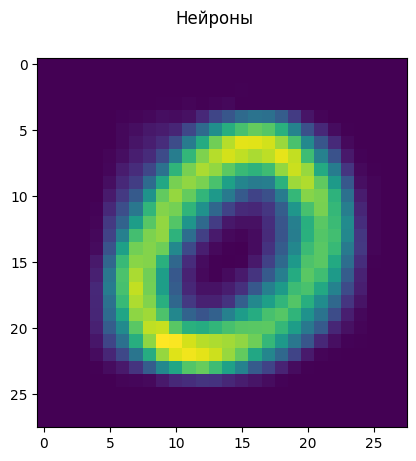

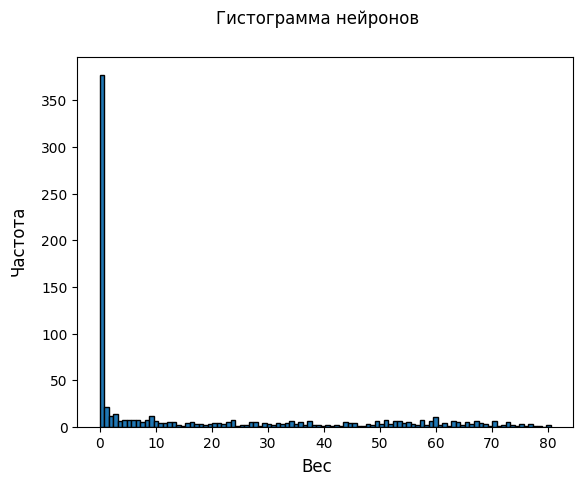

In [10]:
total_loss, scores = LEARNER(i=1, q=1.0)

acc = calc_accuracy(scores, Y_oh, OH_DEC)
print(acc, scores[0])

draw_all_neurons(MODEL.layers[0].neurons)
all_neurons_histo(MODEL.layers[0].neurons)

# DEBUG

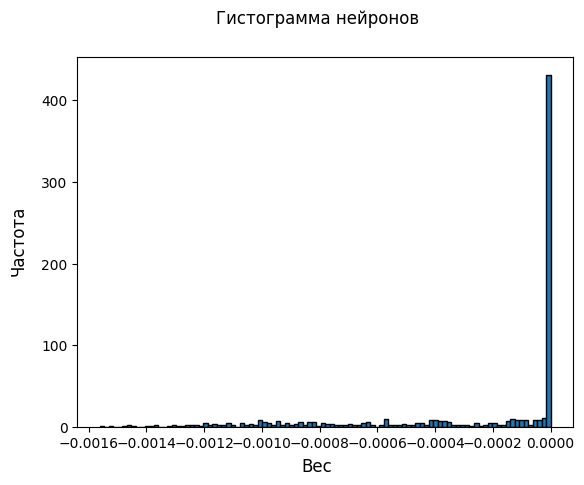

In [11]:
total_loss.backward()
all_neurons_histo(MODEL.layers[0].neurons, key=lambda p: p.grad)

In [25]:
import pandas as pd

numbers = [p.data for p in MODEL.layers[0].neurons[0].parameters()]
numbers.sort()

pd.DataFrame(numbers).describe()

,0
count,784.000000
mean,17.406623
std,24.170293
min,0.000000
25%,0.000000
50%,1.113726
75%,33.642157
max,80.454902
